In [2]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight

import nlpaug.augmenter.word as naw
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

sns.set(rc={'figure.figsize':(20,10)})

# Load train and test data
train_data = pd.read_csv("../data/train_data.csv")
test_data = pd.read_csv("../data/test_data.csv")

print(train_data.head())

# Split train and test data into features and targets
train_features = train_data["lyrics"]
train_targets = train_data["most_common_genre"]

test_features = test_data["lyrics"]
test_targets = test_data["most_common_genre"]

def model_summary(model):
    print("Model summary:")
    print("---------------------------")
    total_params = 0
    for name, param in model.named_parameters():
        param_count = param.numel()
        total_params += param_count
    print(f"Total parameters: {total_params}")

categories = sorted(list(train_targets.unique()))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LyricsDataset(Dataset):
    def __init__(self, data, labels, augment=False, augmentation_rate=0.1):
        self.data = data
        self.labels = labels
        self.augment = augment
        self.augmentation_rate = augmentation_rate
        self.category_to_index = {category: index for index, category in enumerate(categories)}
        
        self.augmenter = naw.SynonymAug(aug_src='wordnet')

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        lyrics = self.data.iloc[index]
        label = self.labels.iloc[index]
        label_index = torch.tensor(self.category_to_index[label], dtype=torch.long).to(device)

        if self.augment:
            lyrics = self.augmenter.augment(lyrics)
            
        return lyrics, label_index
    
class LyricsTextClassificationModel(torch.nn.Module):
    def __init__(self, embedding_model, embedding_dim, categories, model_type = "embedding_then_one_layer", bert_type = "lyricsbert"):
        super(LyricsTextClassificationModel, self).__init__()
        self.embedding_model = embedding_model
        self.embedding_dim = embedding_dim
        self.model_type = model_type
        self.bert_type = bert_type

        if model_type == "embedding_then_one_layer":
            self.sequential = nn.Sequential(
                nn.Linear(self.embedding_dim, len(categories))
            )
        elif model_type == "embedding-then-conv1d":
            if bert_type == "distilbert":
                linear_input_size = 48896
            elif bert_type == "lyricsbert":
                linear_input_size = 18944
            self.sequential = nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=5),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(linear_input_size, 1024),  # Replace ? with the appropriate input size after flattening
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, len(categories))
            )
        elif model_type == "convolution-batch-normalization":
            if bert_type == "distilbert":
                linear_input_size = 48896
            elif bert_type == "lyricsbert":
                linear_input_size = 18944
            self.sequential = nn.Sequential(
                nn.Conv1d(1, 128, kernel_size=5),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(48896, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, len(categories)),
                nn.Sigmoid()
            )
        elif model_type == "fc-with-batch-normalization":
            self.sequential = nn.Sequential(
                nn.Linear(self.embedding_dim, 18944),
                nn.ReLU(),
                nn.BatchNorm1d(18944),
                nn.Flatten(),
                nn.Dropout(0.3),
                nn.Linear(18944, 2048),
                nn.ReLU(),
                nn.BatchNorm1d(2048),
                nn.Dropout(0.3),
                nn.Linear(2048, len(categories)),
                nn.Sigmoid()
            )
    
    def forward(self, input_ids):
        outputs = self.embedding_model.encode(input_ids, convert_to_tensor=True)
            
        # for conv, unsqueeze embedding output
        if self.model_type == "embedding-then-conv1d":
            outputs = outputs.unsqueeze(1)
        logits = self.sequential(outputs)
        return logits
    
def train_and_evaluate(model, model_name, num_epochs, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler = None):
    df = pd.DataFrame(columns=['model', 'epoch', 'train_accuracy', 'test_accuracy', 'f1_score', 'train_loss', 'test_loss', 'train_time_per_step', 'eval_time_per_step'])

    scaler = GradScaler(enabled=use_fp16)

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        train_loss = 0.0
        start_train_time = time.time()

        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()

            with autocast(enabled=use_fp16):
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()

            if (i + 1) % gradient_accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)
            train_loss += loss.item()

        train_time_per_step = (time.time() - start_train_time) / len(train_dataloader)
        train_accuracy = total_correct / total_samples

        model.eval()
        total_correct = 0
        total_samples = 0
        test_loss = 0.0
        start_eval_time = time.time()
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                total_correct += (predictions == labels).sum().item()
                total_samples += labels.size(0)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
                
        
        if scheduler is not None:
            scheduler.step(test_loss)
        
        eval_time_per_step = (time.time() - start_eval_time) / len(test_dataloader)
        test_accuracy = total_correct / total_samples
        f1 = f1_score(np.array(y_true), np.array(y_pred), average='weighted')
        train_loss = train_loss / len(train_dataloader.dataset)
        test_loss = test_loss / len(test_dataloader.dataset)
        print(f"Model {model_name}: Epoch: {epoch+1} Train Accuracy: {train_accuracy:.4f} Test Accuracy: {test_accuracy:.4f} F1 Score: {f1:.4f} Train Loss: {train_loss:.4f} Test Loss: {test_loss:.4f} Train Time/Step: {train_time_per_step:.4f} Eval Time/Step: {eval_time_per_step:.4f}")
        
        temp_df = pd.DataFrame({'model': [model_name], 'epoch': [epoch+1], 'train_accuracy': [train_accuracy], 'test_accuracy': [test_accuracy], 'f1_score': [f1], 'train_loss': [train_loss], 'test_loss': [test_loss], 'train_time_per_step': [train_time_per_step], 'eval_time_per_step': [eval_time_per_step]})
        df = pd.concat([df, temp_df], ignore_index=True)
    # Save the dataframe as a CSV file for each model
    df.to_csv(f'{model_name}_history.csv', index=False)
    df = df.iloc[0:0]

    #for each model to be tested, use the following code to get the confusion matrix and classification report
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=categories)
    print(report)
    sns.heatmap(cm, annot=True, xticklabels=categories, yticklabels=categories, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    return df, model

batchsize = 512
learning_rate = 1e-3
train_dataset = LyricsDataset(train_features, train_targets)
test_dataset = LyricsDataset(test_features, test_targets)
train_dataloader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced",
    classes = np.unique(train_targets),
    y = train_targets  
)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

                       id                                             lyrics  \
0  1FAmKoufyAXMfzPPs9bsjA  i tied my bandana took my pack from the floor ...   
1  3QvPEv8XjHa73iYhaienWw  i want to live on the moon never see a human a...   
2  5VPFATm85G3P04Q5g8yxqr  bitch you know you can t parallel park anyway ...   
3  7J2jCftItt7htcOUdcMnpt  graceless falling slipping in the cold with no...   
4  4cBPzVIbDIQx0LIyauFAy0  madame morse estate stood five hundred years p...   

       artist_name most_common_genre  \
0  Waylon Jennings           country   
1   Phantom Planet              rock   
2    Isaiah Rashad           hip-hop   
3     Matt Pond PA             indie   
4       Ariel Pink               pop   

                                          genre_list  
0  ['country', 'country', 'rock', 'outlaw', 'coun...  
1                                    ['pop', 'rock']  
2  ['hip-hop', 'rap', 'tennessee', 'hip-hop', 'un...  
3                                ['philly', 'indie']  
4  

No sentence-transformers model found with name /home/bruno/.cache/torch/sentence_transformers/distilbert-base-uncased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /home/bruno/.cache/torch/sentence_transformers/distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model summary:
---------------------------
Total parameters: 119792650
None
Model fc-with-batch-normalization-bert-base: Epoch: 1 Train Accuracy: 0.3030 Test Accuracy: 0.3611 F1 Score: 0.3565 Train Loss: 0.0039 Test Loss: 0.0041 Train Time/Step: 0.6643 Eval Time/Step: 1.2909
Model fc-with-batch-normalization-bert-base: Epoch: 2 Train Accuracy: 0.3418 Test Accuracy: 0.2988 F1 Score: 0.2694 Train Loss: 0.0038 Test Loss: 0.0041 Train Time/Step: 0.6393 Eval Time/Step: 1.3673
Model fc-with-batch-normalization-bert-base: Epoch: 3 Train Accuracy: 0.3480 Test Accuracy: 0.3479 F1 Score: 0.3227 Train Loss: 0.0038 Test Loss: 0.0040 Train Time/Step: 0.6447 Eval Time/Step: 1.3686
Model fc-with-batch-normalization-bert-base: Epoch: 4 Train Accuracy: 0.3629 Test Accuracy: 0.3069 F1 Score: 0.2790 Train Loss: 0.0037 Test Loss: 0.0040 Train Time/Step: 0.6414 Eval Time/Step: 1.3795
Model fc-with-batch-normalization-bert-base: Epoch: 5 Train Accuracy: 0.3838 Test Accuracy: 0.3481 F1 Score: 0.3196 Train Lo

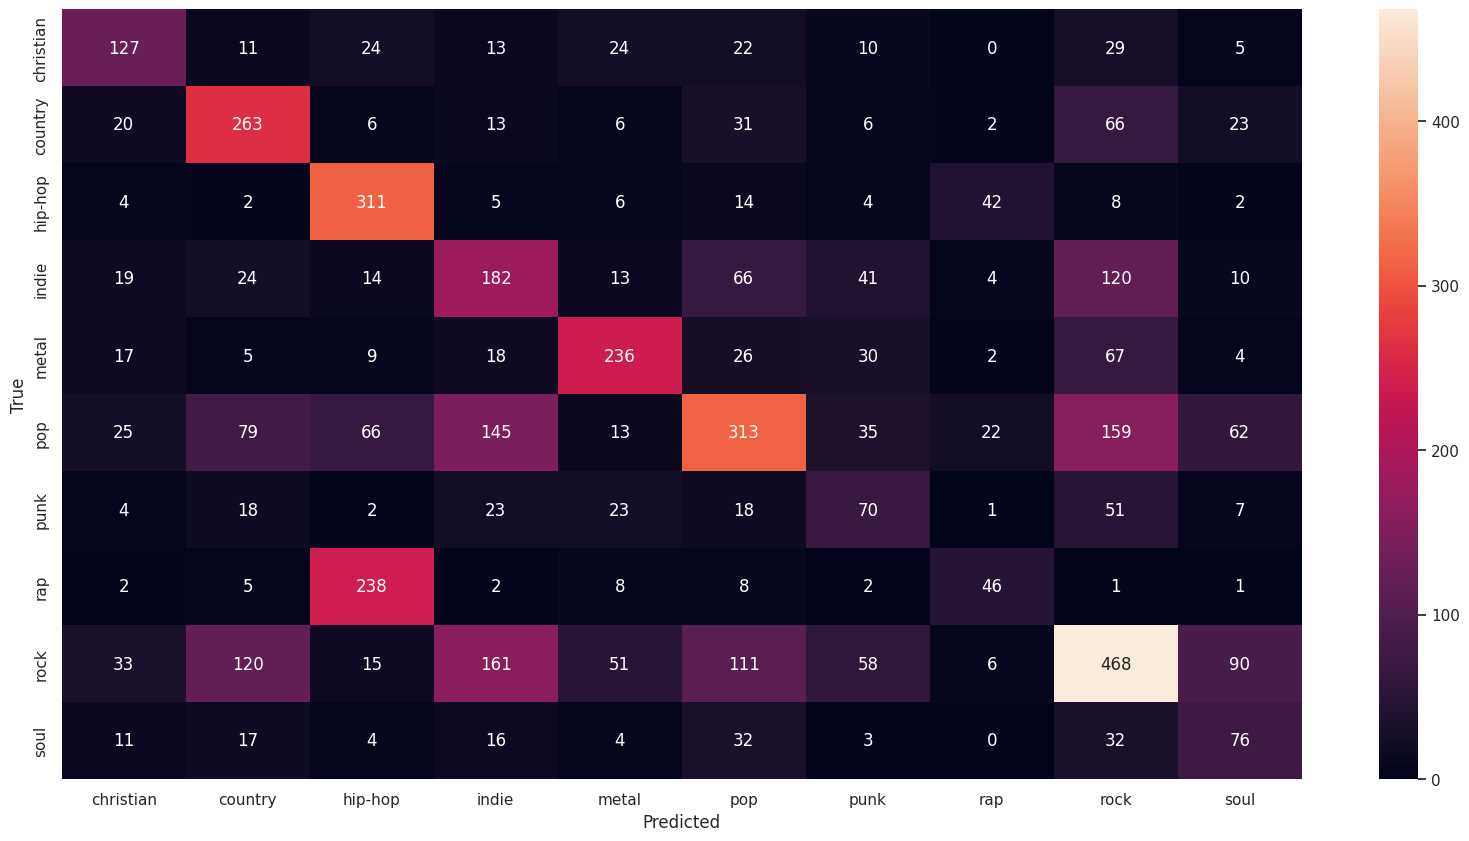

In [3]:
model_name = 'fc-with-batch-normalization-bert-base'

fc_with_batch_normalization_bert_base = LyricsTextClassificationModel(SentenceTransformer("distilbert-base-uncased"), 768, categories, model_type="fc-with-batch-normalization", bert_type="distilbert")
fc_with_batch_normalization_bert_base.to(device)
optimizer = optim.Adam(fc_with_batch_normalization_bert_base.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
print(model_summary(fc_with_batch_normalization_bert_base))
history, model = train_and_evaluate(fc_with_batch_normalization_bert_base, model_name, 25, criterion, optimizer, train_dataloader, test_dataloader, categories, use_fp16=True, gradient_accumulation_steps=1, scheduler=scheduler)

              precision    recall  f1-score   support

   christian       0.48      0.48      0.48       265
     country       0.48      0.60      0.54       436
     hip-hop       0.45      0.78      0.57       398
       indie       0.31      0.37      0.34       493
       metal       0.61      0.57      0.59       414
         pop       0.49      0.34      0.40       919
        punk       0.27      0.32      0.29       217
         rap       0.37      0.15      0.21       313
        rock       0.47      0.42      0.44      1113
        soul       0.27      0.39      0.32       195

    accuracy                           0.44      4763
   macro avg       0.42      0.44      0.42      4763
weighted avg       0.45      0.44      0.43      4763



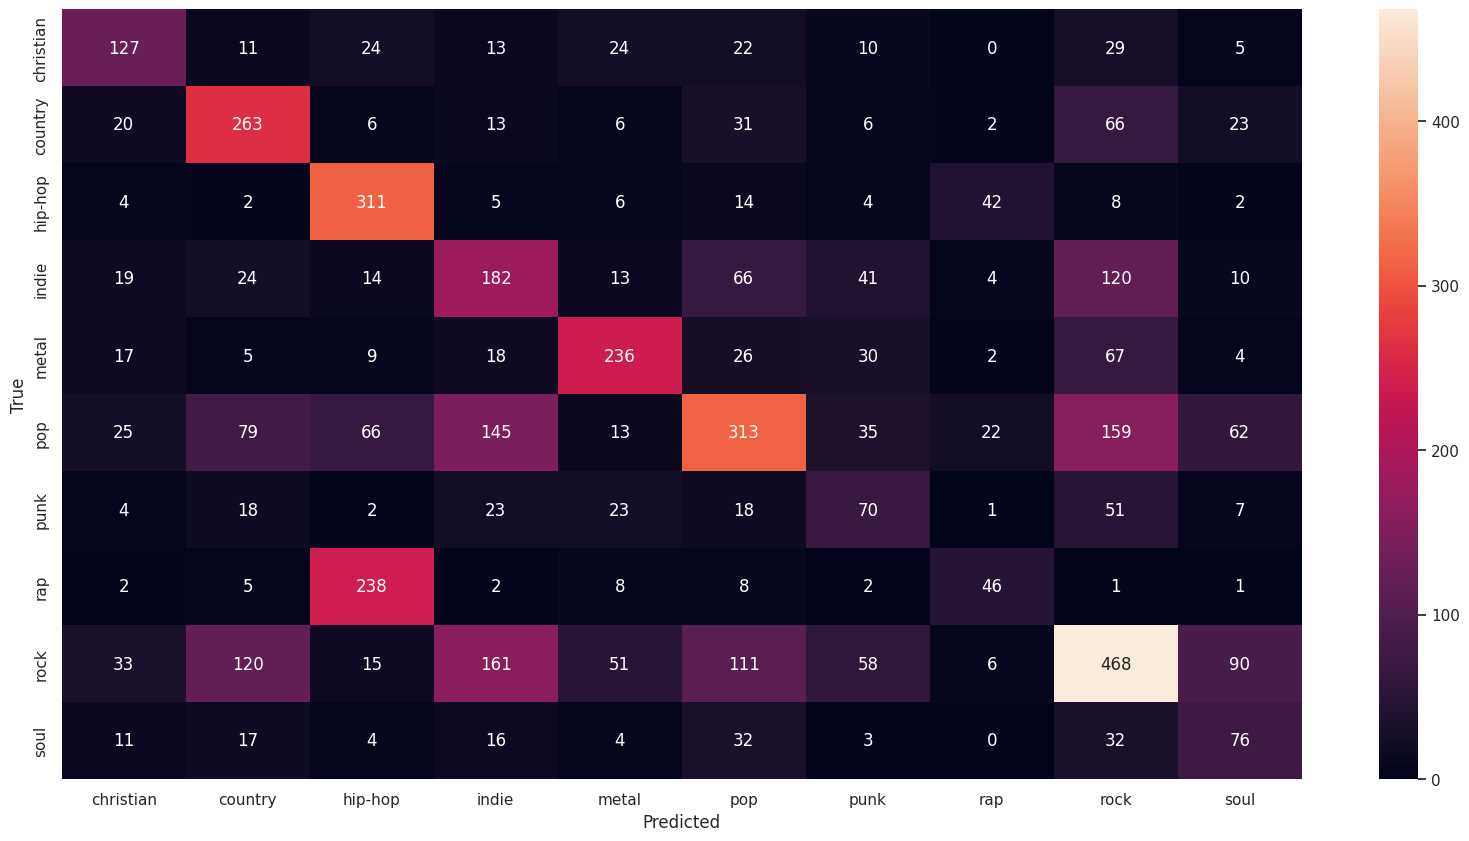

In [6]:
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=categories)

In [15]:
# Assuming 'cm' is your confusion matrix and 'categories' is the list of genres
np.fill_diagonal(cm, 0)  # Set diagonal elements to zero to ignore correct classifications
flattened = cm.flatten()
top_15_indices = np.argpartition(flattened, -15)[-15:]  # Indices of top 15 elements
top_15_pairs = [(np.unravel_index(i, cm.shape), cm[np.unravel_index(i, cm.shape)]) for i in top_15_indices]
top_15_pairs_sorted = sorted(top_15_pairs, key=lambda x: x[1], reverse=True)  # Sort by confusion count
for pair, count in top_15_pairs_sorted:
    print(f"Genres: {categories[pair[0]]} predicted as {categories[pair[1]]}, Count: {count}")

Genres: rap predicted as hip-hop, Count: 238
Genres: rock predicted as indie, Count: 161
Genres: pop predicted as rock, Count: 159
Genres: pop predicted as indie, Count: 145
Genres: indie predicted as rock, Count: 120
Genres: rock predicted as country, Count: 120
Genres: rock predicted as pop, Count: 111
Genres: rock predicted as soul, Count: 90
Genres: pop predicted as country, Count: 79
Genres: metal predicted as rock, Count: 67
Genres: pop predicted as hip-hop, Count: 66
Genres: country predicted as rock, Count: 66
Genres: indie predicted as pop, Count: 66
Genres: pop predicted as soul, Count: 62
Genres: rock predicted as punk, Count: 58


In [21]:
# Assuming 'y_true' are the true labels and 'y_pred' are the predicted labels
correct_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true == pred]
incorrect_indices = [i for i, (true, pred) in enumerate(zip(y_true, y_pred)) if true != pred]

# Print some correctly classified lyrics
print("Correctly classified lyrics:")
for i in correct_indices[:5]:
    print(f"Lyrics: {test_features.iloc[i]}\nTrue Label: {categories[y_true[i]]}")

# Print some misclassified lyrics
print("\n\nMisclassified lyrics:")
for i in incorrect_indices[:5]:
    print(f"Lyrics: {test_features.iloc[i]}, \nPredicted: {categories[y_pred[i]]}, \nTrue: {categories[y_true[i]]}")


Correctly classified lyrics:
Lyrics: i used to live in the darkness dress in black act so heartless but now i see that colors are everything got kaleidoscopes in my hairdo got back the stars in my eyes too yeah now i see the magic inside of me yeah maybe my head s fucked up but i m falling right back in love with being alive dreaming in light light lights this kitty cat lost her mind been lookin for a star sent sign that i ll be alright look to the skies i found a rainbow rainbow baby trust me i know life is scary but just put those colors on girl come and play along with me tonight i d forgot how to daydream so consumed with the wrong things but in the dark i realized this life is short and deep down i m still a child playful eyes wide and wild i can t lose hope what s left of my heart s still made of gold and i know that i m still fucked up but aren t we all my love darling our scars make us who we are are so when the winds are howling strong and you think you can t go on hold tight 

In [22]:
# Assuming 'inputs' are your input lyrics
outputs = model(inputs)
probabilities = F.softmax(outputs, dim=1)
_, predictions = torch.max(outputs, 1)

# Print predictions with confidence levels
for i in range(len(predictions)):
    print(f"Example {i}: Predicted class: {categories[predictions[i]]}, Confidence level: {probabilities[i][predictions[i]]:.2f}")


Example 0: Predicted class: rock, Confidence level: 0.21
Example 1: Predicted class: hip-hop, Confidence level: 0.20
Example 2: Predicted class: rock, Confidence level: 0.20
Example 3: Predicted class: country, Confidence level: 0.20
Example 4: Predicted class: rock, Confidence level: 0.18
Example 5: Predicted class: hip-hop, Confidence level: 0.21
Example 6: Predicted class: indie, Confidence level: 0.19
Example 7: Predicted class: indie, Confidence level: 0.18
Example 8: Predicted class: indie, Confidence level: 0.22
Example 9: Predicted class: metal, Confidence level: 0.20
Example 10: Predicted class: rock, Confidence level: 0.20
Example 11: Predicted class: indie, Confidence level: 0.19
Example 12: Predicted class: indie, Confidence level: 0.19
Example 13: Predicted class: rock, Confidence level: 0.20
Example 14: Predicted class: rock, Confidence level: 0.21
Example 15: Predicted class: rap, Confidence level: 0.20
Example 16: Predicted class: hip-hop, Confidence level: 0.18
Example